In [1]:
import csv
import cv2
import sys
import pickle
import random
import numpy as np

import os
import json

import matplotlib.pyplot as plt

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, ELU
from keras.regularizers import l2

from sklearn.preprocessing import LabelBinarizer

from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
print("module imported")

module imported


In [3]:
#ch, row, col = 3, 160, 320
channels, rows, columns = 3, 66, 200  # camera format

In [4]:

#Fetch data from pickle file
with open('data/driving_data.p', mode='rb') as f:
    driving_data = pickle.load(f)

center_images = driving_data['center_images']
left_images = driving_data['left_images']
right_images = driving_data['right_images']
labels = driving_data['labels']

#shuffle a dataset
images, labels = shuffle(center_images, labels)

# split train & valid data
X_train, X_validation, y_train, y_validation = train_test_split(center_images, labels, test_size=0.1, random_state=42)

print(len(X_train))
print(len(X_validation))

13847
1539


In [5]:

#custom rows and columns to fit Nvidia model
custom_rows, custom_cols = 66, 200

def flip_image(image, angle):
    if random.randint(0, 1):
        return cv2.flip(image, 1), -angle
    else:
        return image, angle
    
def rotate_image(image, angle):
    rows,cols,channel = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(-5, 5), 1)
    return cv2.warpAffine(image,M,(cols,rows)), angle

def brightness_image(image, steering):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.3, 1.2)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), steering

def cut_image(img):
    rows,cols,channel = img.shape
    top = int(.4 * rows)
    botton = int(.85 * rows)
    border = int(.05 * cols)
    return img[top:botton, border:cols-border, :]

#Crop image as required
#http://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
def crop_image(image, y1, y2, x1, x2):
    return image[y1:y2, x1:x2]

#translate image and compensate for the translation on the steering angle
def translate_image(image, steering, horz_range=30, vert_range=5):
    rows, cols, chs = image.shape
    tx = np.random.randint(-horz_range, horz_range+1)
    ty = np.random.randint(-vert_range, vert_range+1)
    steering = steering + tx * 0.004 # multiply by steering angle units per pixel
    tr_M = np.float32([[1,0,tx], [0,1,ty]])
    image = cv2.warpAffine(image, tr_M, (cols,rows), borderMode=1)
    return image, steering

def augment_image(image, angle):
    
    #Flip
    image, angle = flip_image(np.copy(image),angle)
    
    #Crop
    #image = crop_image(image, 20, 140, 50, 270)
    image = cut_image(image)
    
    #Rotate image
    #image, angle = rotate_image(image,angle)
    
    #Translate. This will help with sharp turnings
    image, steering = translate_image(np.copy(image), angle)
    
    #Brightness
    image, angle = brightness_image(np.copy(image),angle)
    
    #Data normalization
    #image = (image - 128.0) / 128.0
    
    return image, angle

def get_image(center_images, left_images, right_images, labels, index, image_offset=0.25):
    
    camera = np.random.choice(['center', 'left', 'right'])
    
    if camera == 'center':
        image, steering = plt.imread("data/"+center_images[index]), float(labels[index])
    elif camera == 'left':
        image, steering = plt.imread("data/"+left_images[index]), float(labels[index])+image_offset
    elif camera == 'right':
        image, steering = plt.imread("data/"+right_images[index]), float(labels[index])-image_offset
    
    #image and steering
    #image, steering = plt.imread("data/"+car_images[index]), float(labels[index])
    
    #Augment image 
    image, angle = augment_image(image, steering)
    
    #Resize image
    image = cv2.resize(image, (custom_cols, custom_rows))
    image = np.reshape(image, (1, custom_rows, custom_cols, channels))
    return image, steering


#Custom generator for model training
def my_generator(center_images, left_images, right_images, labels, batch_size):
    batch_train = np.zeros((batch_size, rows, columns, 3))
    batch_angle = np.zeros(batch_size)
    while True:
        for index in range(batch_size):
            image, angle = get_image(center_images, left_images, right_images, labels, index)
            batch_train[index], batch_angle[index] = image, angle
        yield batch_train, batch_angle
 

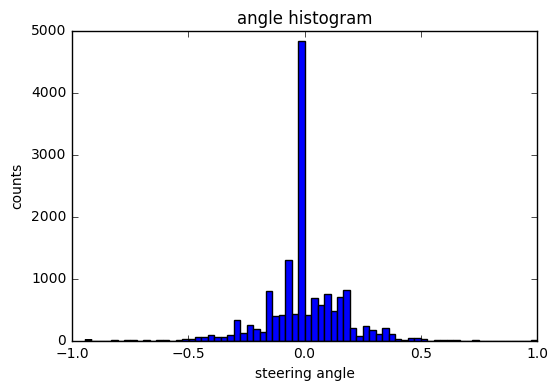

In [6]:
# histogram of labels count

plt.hist(labels, bins=70)
plt.title('angle histogram')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()


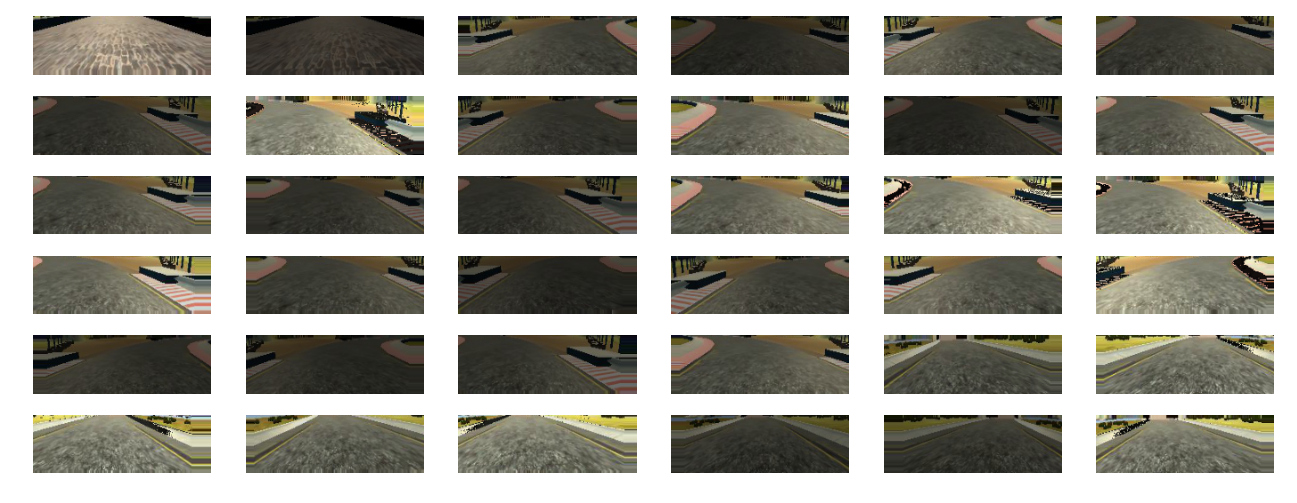

In [7]:
#Randomly print few images
plt.figure(figsize=(16,6))
for i in range(36):
    #random_index = np.random.randint(0,len(center_images))
    image,angle = get_image(center_images, left_images, right_images, labels, i)
    #image,angle = get_image1(center_images, labels, i)
    plt.subplot(6,6,i+1)
    plt.imshow(image.squeeze(), cmap="gray");
    plt.axis('off')
plt.show()

In [8]:
def commaai_model(time_len=1):

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(16, 8, 8, input_shape=(3,160,320), subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    return model

def nvidia_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    # W_regularizer=l2(reg_val)
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Flatten())

    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ELU())
    
    model.add(Dense(1))

    #model.compile(optimizer="adam", loss="mse") # , metrics=['accuracy']
    
    return model


In [9]:
batch_size = 64
EPOCHS = 7

model = nvidia_model()

#print model summary
#model.summary()

# Compile model using Adam optimizer
# and loss computed by mean squared error
model.compile(loss='mean_squared_error',
              optimizer=Adam(0.0001),
              metrics=['accuracy'], 
              validation_data=(X_validation, y_validation), 
              verbose=1)

my_generator = my_generator(center_images, left_images, right_images, labels, batch_size)

# Model training
history = model.fit_generator(
    my_generator,
    samples_per_epoch=batch_size*(int((len(center_images)/batch_size))-1), # of training samples
    nb_epoch=EPOCHS,
    verbose=1
)

print("model training complete")

/Users/khaleel.pasha/anaconda/envs/selfDrivingCarCourseEnvironment/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1917: UserWarning: Expected no kwargs, you passed 2
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/7
15296/15296 [==============================] - 159s - loss: 1.8085 - acc: 0.1109   
Epoch 2/7
15296/15296 [==============================] - 243s - loss: 1.2447 - acc: 0.1151   
Epoch 3/7
 3840/15296 [======>.......................] - ETA: 131s - loss: 0.9361 - acc: 0.1141

KeyboardInterrupt: 

In [10]:
#Save the model
model_json = 'model.json'
model_weights = 'model.h5'

json_string = model.to_json()
try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass

with open(model_json, 'w') as jfile:
    json.dump(json_string, jfile)
model.save(model_weights)

print("model saved")

model saved
